In [1]:
!pip install -q --upgrade accelerate transformers ftfy
!pip install -q git+https://github.com/huggingface/diffusers
# !pip install -q diffusers


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("./notebook-output/stable_diffusion_weights/wright-flyer", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("./notebook-output/stable_diffusion_weights/wright-flyer", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "./notebook-output/stable_diffusion_weights/wright-flyer", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "./notebook-output/stable_diffusion_weights/wright-flyer", subfolder="unet", use_safetensors=True
)

In [4]:
from diffusers import DDIMScheduler

scheduler = DDIMScheduler.from_pretrained("./notebook-output/stable_diffusion_weights/wright-flyer", subfolder="scheduler")

In [5]:
# torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)
print("loaded")

loaded


In [6]:
prompt = ["a photo of a awrtflyr airplane"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 50  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance

generator = torch.manual_seed(0)  # Seed generator to create the inital latent noise

batch_size = len(prompt)

In [18]:
import numpy as np

text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_encoder_args = text_input.input_ids.to(torch_device)
    np.save("text_encoder_args.npy", text_encoder_args.detach().cpu().numpy())
    text_embeddings = text_encoder(text_encoder_args)[0]
    np.save("text_embeddings.npy", text_embeddings.detach().cpu().numpy())

In [24]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

np.save("uncond_input.npy", uncond_input.input_ids)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
np.save("uncond_embeddings.npy", uncond_embeddings.detach().cpu().numpy())


tensor([[49406, 49407,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])


In [25]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [26]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

/tmp/ipykernel_5699/2341608825.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [27]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        np.save("latent_model_input.npy", latent_model_input.detach().cpu().numpy())
        np.save("t.npy", t.detach().cpu().numpy())
        np.save("encoder_hidden_states.npy", text_embeddings.detach().cpu().numpy())
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        np.save("noise_pred.npy", noise_pred.detach().cpu().numpy())

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/50 [00:00<?, ?it/s]

In [28]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    np.save("latents.npy", latents.detach().cpu().numpy())
    image = vae.decode(latents).sample
    np.save("image.npy", image.detach().cpu().numpy())


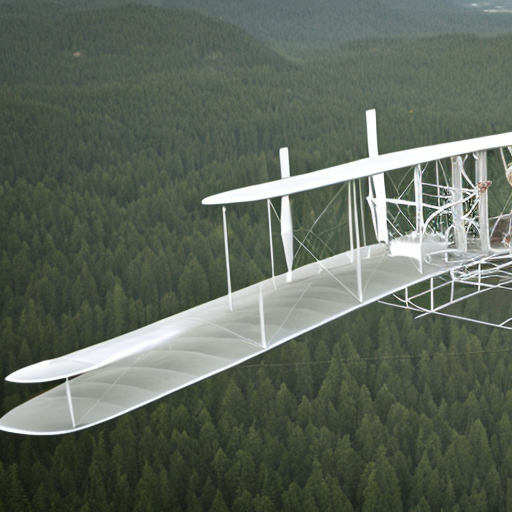

In [29]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
images = (image * 255).round().astype("uint8")
image = Image.fromarray(image)
image